# L02 Model creation and fine tunning

**Siamese neural networks**

Tell how similar two images are by comparing them in a model.Feed neural network with two images and then create an encoding of each images. The final result will be two vectors that will be compared.


## **Import libraries**

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

## 1. Load data

Using the provided set of pairs for the verification task, load and display a few a samples.

In [41]:
# Define folder for data.
DATASET = "./data/CompCars/data"
PAIR_FOLDER = os.path.join(DATASET, "train_test_split/verification")
PAIR_EASY = "verification_pairs_easy.txt"

# Load sets of pairs.
PAIRS_EASY = pd.read_csv(os.path.join(PAIR_FOLDER, PAIR_EASY),names = ["image1", "image2", "similarity"], sep = " ")


In [77]:
len(PAIRS_EASY)

20000

In [73]:
np.random.randint(0, 1000)

323

In [86]:
similar_pairs

,image1,image2,similarity
0,67/1698/2010/6805eb92ac6c70.jpg,67/1698/2011/49d3b39a88dce5.jpg,1
1,83/369/2010/378d0ac3f23328.jpg,83/369/2012/96781ce82816fa.jpg,1
2,159/1585/2013/2de634463f833b.jpg,159/1585/2013/23ab0da221a8c8.jpg,1
3,128/1892/2014/15c0e30c3aa076.jpg,128/1892/2014/244f10d7d96ea2.jpg,1
4,74/1298/2009/955f9a57aade99.jpg,74/1298/2009/95419cea535fde.jpg,1
...,...,...,...
9995,127/1176/2011/e1e1de6aaeb874.jpg,127/1176/2012/86f2d8f55bd1d8.jpg,1
9996,50/1122/2009/8fafd65e90f22d.jpg,50/1122/2009/d7931d91170235.jpg,1
9997,124/1409/2011/ea379ed8f772cf.jpg,124/1409/2011/d5308486b7990e.jpg,1
9998,154/1054/2012/77a8ca2c429f11.jpg,154/1054/2012/d1ef698e8f109d.jpg,1


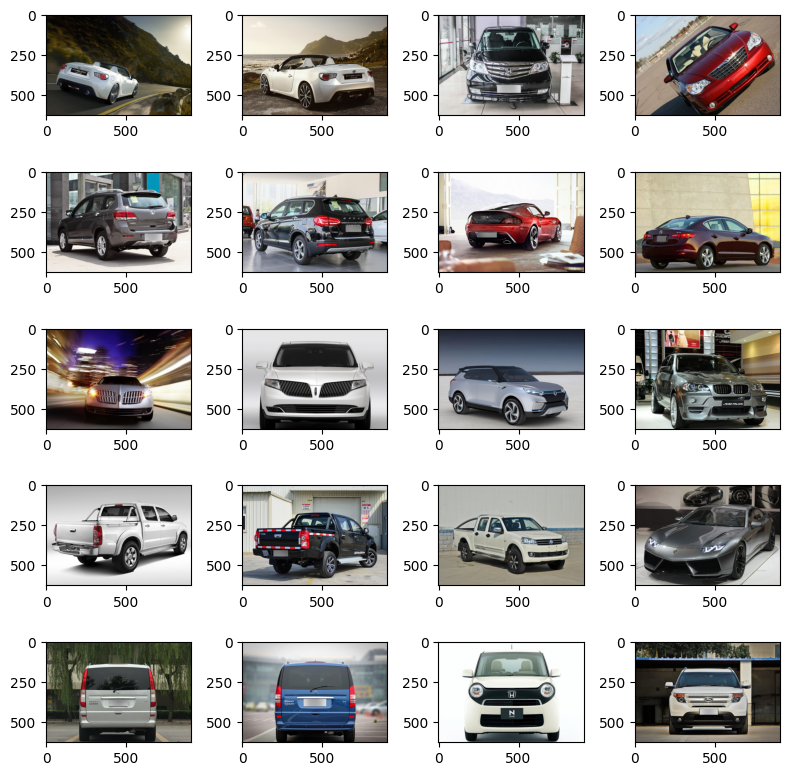

In [94]:
PATH_TO_IMAGE = os.path.join(DATASET, "image")
nonsimilar_pairs = PAIRS_EASY[PAIRS_EASY["similarity"] == 0]
similar_pairs = PAIRS_EASY[PAIRS_EASY["similarity"] == 1]

n_samples = 5
fig, axis = plt.subplots(n_samples, 4, figsize = (8,8))

for idx in range(n_samples):
    # Take a random number.
    r_number = np.random.randint(0, 10000)
    # Draw images with similarity 1
    image_1 = os.path.join(PATH_TO_IMAGE, similar_pairs["image1"].iloc[r_number])
    image_2 = os.path.join(PATH_TO_IMAGE, similar_pairs["image2"].iloc[r_number])
    axis[idx,0].imshow(cv2.cvtColor(cv2.imread(image_1), cv2.COLOR_BGR2RGB))
    axis[idx,1].imshow(cv2.cvtColor(cv2.imread(image_2), cv2.COLOR_BGR2RGB))

    # Draw images with similarity 0
    image_1n = os.path.join(PATH_TO_IMAGE, nonsimilar_pairs["image1"].iloc[r_number])
    image_2n = os.path.join(PATH_TO_IMAGE, nonsimilar_pairs["image2"].iloc[r_number])
    axis[idx,2].imshow(cv2.cvtColor(cv2.imread(image_1n), cv2.COLOR_BGR2RGB))
    axis[idx,3].imshow(cv2.cvtColor(cv2.imread(image_2n), cv2.COLOR_BGR2RGB))

plt.tight_layout()

## 2. Create models

### 2.1 Siamese Network

Neural Network Architecture capable of training pair of samples and analyzing how similar they are. Useful for verification tasks. Consists of two identical networks whose obtained encoded vectors are used for determining similarity. 

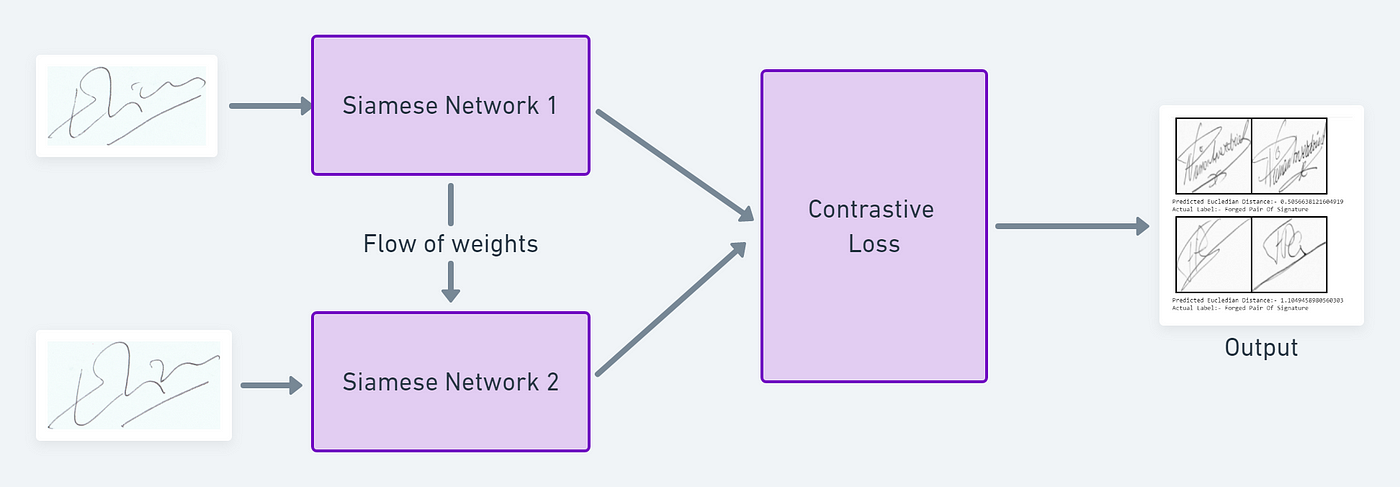

In [2]:
class SiameseNeuralNetwork(nn.Module):
    """
    Siamese Neural Network for performing image verification. Consists on 3 convolutional layers
    and 3 fully connected layers. Input and output shapes can be tune up.

    Parameters:
    number_channels (int): Number of channels of the input image.
    length_a (int): Number of channels for first convolutional layer.
    length_b (int): Number of channels for second convolutional layer.
    length_c (int): Number of channels for third convolutional layer.
    flatten_a (int): Number of neurons for the first fully connected layer.
    flatten_b (int): Number of neurons for the second fully connected layer.

    Method:
    forward_all(x): Computes feature vector for one sample.
    forward(input_a, input_b): Computes feature vector for two samples.
    """

    def __init__(self,number_channels, length_a, length_b, length_c, flatten_a, flatten_b):
        super(SiameseNeuralNetwork, self).__init__(number_channels)
        self.number_channels = number_channels

        # Create three convolutional layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(number_channels, length_a, kernel_size = 11, stride = 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
    
            nn.Conv2d(length_a, length_b, kernel_size = 5, stride = 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),
        
            nn.Conv2d(length_b, length_c,  kernel_size = 3, stride = 1),
            nn.ReLU(inplace=True),
        )

        # Create two fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(length_c, flatten_a),
            nn.ReLU(inplace=True),
            nn.Linear(flatten_a, flatten_b),
            nn.ReLU(inplace=True),
            nn.Linear(flatten_b, 2)
        )
    
    def forward_all(self, x):
        """
        Pass image tensor through convolutional and fully connected layer.

        Parameters:
        x (tensor) -> image tensor from dataset.

        Output:
        output (array) -> encoded vector.
        """
        output = self.cnn1(x)
        # Take batch dimension and multiply the rest.
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input_a, input_b):
        """
        Main forward function that passes two images in the Siamese Network
        for computing encoding vectors.

        Parameters:
        input_a (tensor) -> image tensor from dataset.
        input_b (tensor) -> image tensor from dataset.

        Output:
        output1 (array) -> encoded vector.
        output2 (array) -> encoded vector.
        """
        output1 = self.forward_all(input_a)
        output2 = self.forward_all(input_b)

        return output1, output2

### 2.2 Contrastive Loss

Used to learn embeddings that gets similar pairs closer and separates dissimilar pairs. 


The contrastive loss is defined as:

$$
\left ( 1-Y \right )\left ( \frac{1}{2} \right )\left ( D_{W} \right )^{2} +\left ( Y \right )\frac{1}{2}\left\{max\left ( 0,m-D_{W} \right ) \right\}^{2}
$$

Where:
- Y: Label saying if the pairs are similar.
- D: Euclidean distance between two encoded vectors.
- m: Margin that defines minimum distance for dissimilar pairs.

In [3]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive Loss function to compute how similar are a pair of encoded vectors.


    """
    def __init__(self, margin = 2.6):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
    
    def forward(self, output_a, output_b, label):
        """
        Contrastive loss function.

        Args:
            output_a (tensor): encoded vector for image a.
            output_b (tensor): encoded vector for image b.
            label (int): similarity label, 0 if it's similar, 1 if it's not.

        Output:
            loss_contrastive (float): loss
        """
        euclidean_distance = F.pairwise_distance(output_a, output_b, keepdim=True)

        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

### 2.3 Triplet loss

The triplet loss is defined as:

$$
\mathcal{L} = \sum_{i=1}^N \left[ \| f(x_a^i) - f(x_p^i) \|_2^2 - \| f(x_a^i) - f(x_n^i) \|_2^2 + \alpha \right]_+
$$

In [4]:
class TripletLoss(nn.Module):
    """
    Triplet Loss function to ensure the anchor is closer to the positive than to the negative.
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        """
        Compute Triplet Loss.

        Args:
            anchor (torch.Tensor): Encoded vector for the anchor.
            positive (torch.Tensor): Encoded vector for the positive sample.
            negative (torch.Tensor): Encoded vector for the negative sample.

        Returns:
            torch.Tensor: Triplet loss value.
        """

        positive_distance = F.pairwise_distance(anchor, positive)  # Distance between anchor and positive
        negative_distance = F.pairwise_distance(anchor, negative)  # Distance between anchor and negative

        loss = torch.mean(torch.clamp(positive_distance - negative_distance + self.margin, min=0.0))
        return loss
